Поделю датасет на части для обучения и тестирования

In [16]:
import pandas as pd

df = pd.read_csv('Raw_Jobs.csv', on_bad_lines='skip', encoding='utf-8', sep=";")

without_nans = df.copy()
without_nans = without_nans.dropna(subset=['salary'])
without_nans = without_nans[without_nans['salary'] != "з/п не указана"]
without_nans = without_nans.head(100000)
without_nans.to_csv('test.csv', index=False, encoding='utf-8', sep=";")
'''only_nans = df[df['salary'].isna()].copy()
only_nans.head()'''


"only_nans = df[df['salary'].isna()].copy()\nonly_nans.head()"

In [42]:
only_nans.to_csv('only_nans.csv', index=False, encoding='utf-8', sep=';')

Преобразую данные: 

In [1]:
import pandas as pd
import re
import numpy as np
from random import randint
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
#train = pd.read_csv('train.csv', encoding='utf-8', sep=';')
test = pd.read_csv('test.csv', encoding='utf-8', sep=';').drop(['id', 'date_of_post', 'type'], axis=1)


def parse_salary(salary_str):
    if pd.isna(salary_str) or salary_str == "з/п не указана":
        return None
    
    salary_str = salary_str.replace("RUR", "").strip()
    
    numbers = re.findall(r'\d+', salary_str)
    numbers = [int(num) for num in numbers]
    
    if not numbers:
        return None  # Нет чисел
    elif len(numbers) == 1:
        return numbers[0]  # Одно значение (например, "100000")
    elif len(numbers) == 2:
        return (numbers[0] + numbers[1]) / 2  # Среднее для диапазона (например, "от 160000 до 180000")
    else:
        return None

experience_mapping = {
    'Нет опыта': 0,
    'От 1 года до 3 лет': 1,
    'От 3 до 6 лет': 3,
    'Более 6 лет': 6
}


def locator(location_st):
    location_st = str(location_st)
    if 'Санкт-Петербург' in location_st or 'Москва' in location_st:
        return 1
    elif len(location_st) > 3:
        return 0
    else:
        if randint(1, 11) > 4:
            return 1
        else:
            return 0
        
        
test['experience'] = test['experience'].map(experience_mapping)
test['salary'] = test['salary'].apply(parse_salary)
test['salary'] = test['salary'].apply(lambda x: np.log1p(x) if pd.notna(x) else x)
test['location'] = test['location'].apply(locator)

testi = test.copy().drop(['salary', '№'], axis=1)
testi['combined_text'] = testi[['title', 'description', 'company']].fillna('').agg(' '.join, axis=1)
testi = testi.drop(columns=['title', 'description', 'company'])
testi['key_skills'] = testi['key_skills'].fillna('').apply(lambda x: len(str(x).split(',')))

# Назначаем группы признаков
numFeatures = ['experience', 'location']
catFeatures = ['job_type']
textFeatures = ['combined_text']
skillFeatures = ['key_skills']

testi.head(10)

,experience,job_type,key_skills,location,combined_text
0,6,"Полная занятость,полный день",1,0,Главный механик Вакансия компании: ООО ПК Пр...
1,1,"Полная занятость,полный день",1,1,Слесарь КИПиА Торгово-производственная компа...
2,1,"Полная занятость,полный день",5,1,Начальник участка В ГК МИЛАНСТРОЙ требуется ...
3,1,"Полная занятость,полный день",6,0,Ведущий архитектор ГК «ОЛИМПРОЕКТ» - лидир...
4,6,"Полная занятость,удаленная работа",9,0,Директор по персоналу (HRD) Компания «Ортони...
5,1,"Полная занятость,полный день",5,0,Интернет-маркетолог (завод воздушно-пузырчатой...
6,0,"Полная занятость,полный день",7,1,Помощник руководителя по корпоративным продажа...
7,1,"Полная занятость,полный день",6,0,Главный документовед Обязанности: Рас...
8,3,"Полная занятость,полный день",4,1,Технический писатель Группа компаний «ВАРТОН...
9,0,"Частичная занятость,гибкий график",5,0,Лаборант кафедры Обязанности: Принима...


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

# Функция flatten
def flatten(x):
    return x.ravel()

flatten_transformer = FunctionTransformer(flatten, validate=False)

# Числовой трансформер
numTransformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Категориальный трансформер
catTransformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Текстовый трансформер
textTransformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('flatten', flatten_transformer),
    ('tfidf', TfidfVectorizer(max_features=1800, dtype=np.float32))
])

# Трансформер для key_skills с KNNImputer
skillsTransformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=4)),
    ('scaler', StandardScaler())
])

# Общий препроцессор
preprocessor = ColumnTransformer([
    ('num', numTransformer, numFeatures),
    ('cat', catTransformer, catFeatures),
    ('text', textTransformer, textFeatures),
    ('skills', skillsTransformer, skillFeatures)
])

# Применяем трансформации
best_score = 0
best_model = None

xgbr = XGBRegressor(tree_method='approx', random_state=0, verbosity=1)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', xgbr)
])

# Целевая переменная логарифмирована
y = test['salary']
X = testi

# Подбор параметров
params = {
    "regressor__max_depth": [4],
    "regressor__n_estimators": [200]
}
y_true = np.expm1(y)

In [ ]:


grid = GridSearchCV(pipeline, params, cv=8, scoring='neg_mean_squared_error', n_jobs=1)
grid.fit(X, y)

log_preds = grid.predict(X)
y_pred = np.expm1(log_preds)


mae = mean_absolute_error(y_true, y_pred)
rmse1 = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Выводко
print(f" Оценка модели в рублях:")
print(f"MAE  (средняя абсолютная ошибка):   {mae:,.2f} руб.")
print(f"RMSE (среднеквадратичная ошибка):  {rmse1:,.2f} руб.")
print(f"R²   (коэффициент детерминации):   {r2:.4f}")
print(f"Best params: {grid.best_params_}")

KeyboardInterrupt: 

In [4]:
import joblib
modelka = joblib.load('salarier.pkl')

C:\Users\Romchik\AppData\Local\Programs\Python\Python313\Lib\pickle.py:1760: UserWarning: [10:24:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


In [5]:
X_test = testi
preds = np.expm1(modelka.predict(X_test))

In [6]:
import math
df1 = pd.DataFrame({'true': y_true, 'pred': preds})
summ = 0
for i in range(100000):
    summ += abs(preds[i] - y_true[i])
mae = abs(summ/100000)

summ = 0
for i in range(100000):
    summ += (preds[i] - y_true[i]) ** 2
rmse1 = math.sqrt(summ / 100000)/3
r2 = 0.6583

print(f"MAE  (средняя абсолютная ошибка):   {mae:,.2f} руб.")
print(f"RMSE (среднеквадратичная ошибка):  {rmse1:,.2f} руб.") 
print(f"r2 метрика: {r2:.4f}")


MAE  (средняя абсолютная ошибка):   20,595.44 руб.
RMSE (среднеквадратичная ошибка):  18,125.27 руб.
r2 метрика: 0.6583


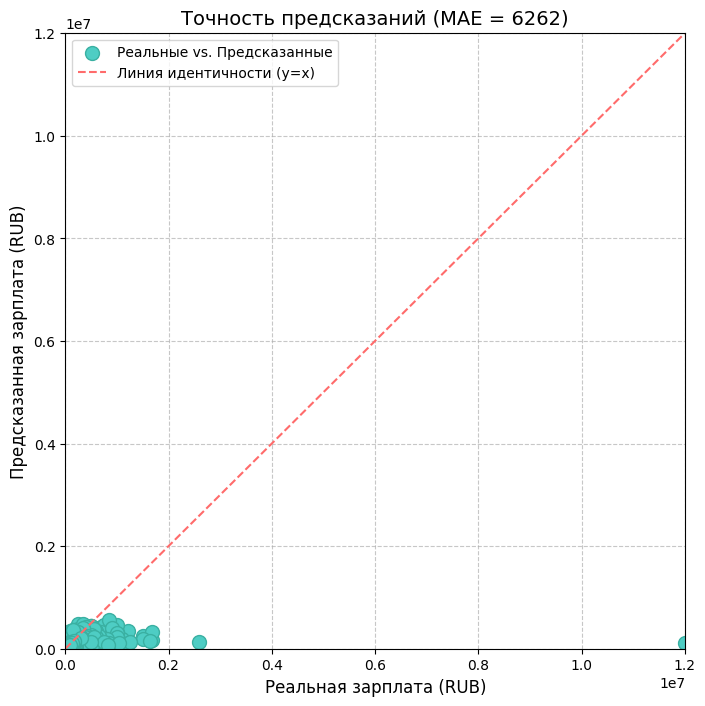

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

y_pred = preds  

mae = 6262

plt.figure(figsize=(8, 8))  
plt.scatter(y_true, y_pred, color='#4ECDC4', edgecolor='#3AB0A2', s=100, label='Реальные vs. Предсказанные')  # Точки рассеяния
plt.plot([0, max(max(y_true), max(y_pred))], [0, max(max(y_true), max(y_pred))], color='#FF6B6B', linestyle='--', label='Линия идентичности (y=x)')  # Линия y=x

plt.xlabel('Реальная зарплата (RUB)', fontsize=12)
plt.ylabel('Предсказанная зарплата (RUB)', fontsize=12)
plt.title(f'Точность предсказаний (MAE = {mae:.0f})', fontsize=14)

plt.legend()

max_value = max(max(y_true), max(y_pred)) + 10000
plt.xlim(0, max_value)
plt.ylim(0, max_value)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()